# Bayesian Linear Regression

Benjamin T. Vincent, [@inferenceLab](https://twitter.com/inferencelab)

## Introduction
This notebook is intended as a very brief introduction into some of the concepts used in the Bayesian approach. We will look at an example which everyone is familiar with, linear regression, in order to focus upon the concepts rather than the model itself.

This is an example of "descriptive modelling" where in the majority of cases, linear modelling is meant to _describe_ data that we have observed as opposed to _explaining_ it. We will explore explanatory models in the next notebooks.

In [1]:
using Distributions, StatsPlots, Turing

## Simulate some fake data

In [2]:
β₀ = 4  # intercept
β₁ = -2  # slope
σ = 0.5  # observation noise
N = 20;  # sample size

The line below defines our simple linear regression model.

In [3]:
linear_regression(x, β₀, β₁) = β₀ + β₁ * x;

In [4]:
x = rand(Normal(0, 1), N)
y = rand.(Normal.(linear_regression.(x, β₀, β₁), σ));

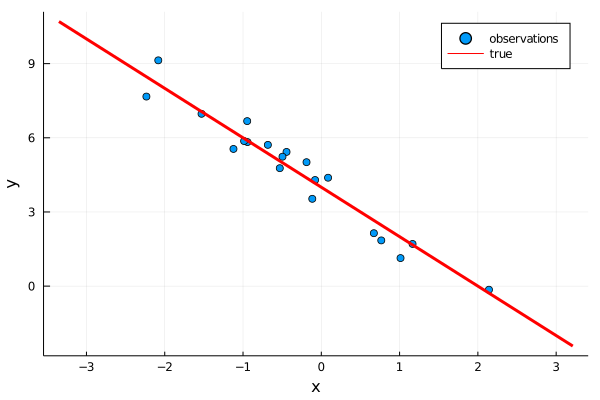

In [5]:
scatter(x, y, xlabel="x", ylabel="y", label="observations")
LinRange(minimum(x)*1.5, maximum(x)*1.5, 50) |>
    x -> plot!(x, linear_regression.(x, β₀, β₁), label="true", lw=3, color=:red)

## Bayesian linear regression model
Wonder at the beauty of how minimal this Bayesian model of linear regression is! 

In [6]:
@model function bayesian_linear_regression(x, y)
    
    # Priors
    β₀ ~ Normal(0, 1)
    β₁ ~ Normal(0, 1)
    σ ~ TruncatedNormal(0, 1, 0, Inf)
    
    # Likelihood
    @. y ~ Normal(linear_regression(x, β₀, β₁), σ)
    
end;

## Sample from the prior

In [7]:
# sample from the prior
prior = sample(bayesian_linear_regression(x, y), Prior(), 5_000);

Sampling: 100%|█████████████████████████████████████████| Time: 0:00:00


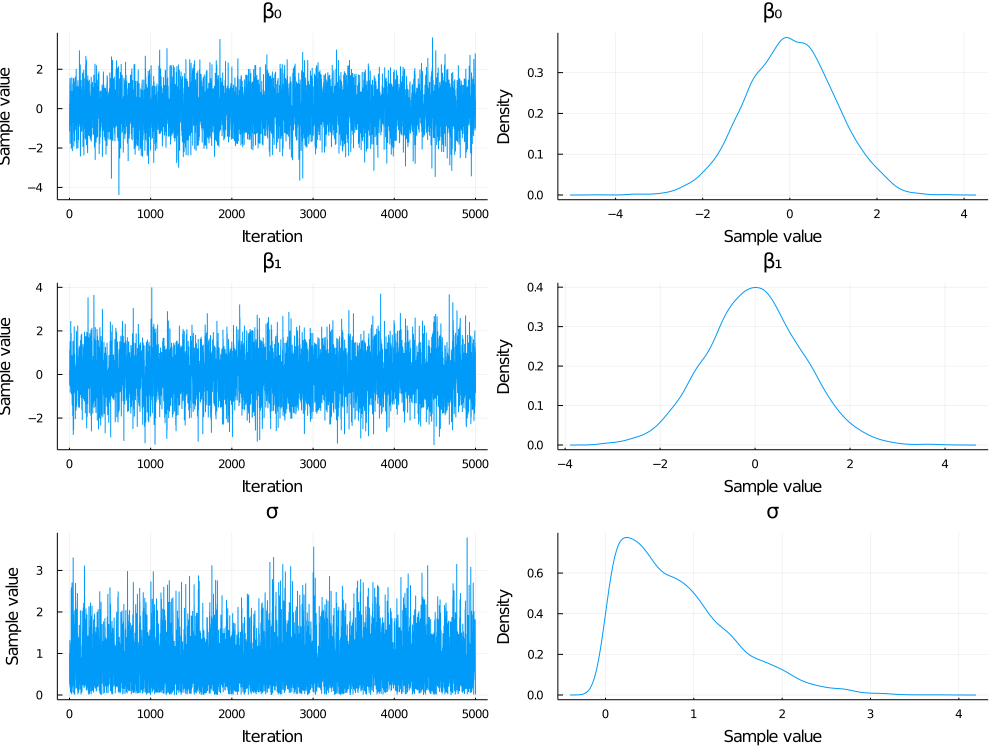

In [8]:
plot(prior)

With this simple linear regression model it is fairly clear to understand how the priors will affect what the model predicts. But this is not always the case with more complex models, so it can be useful to make prior predictive plots. This let's you check that your priors over parameters reflect your beliefs about data.

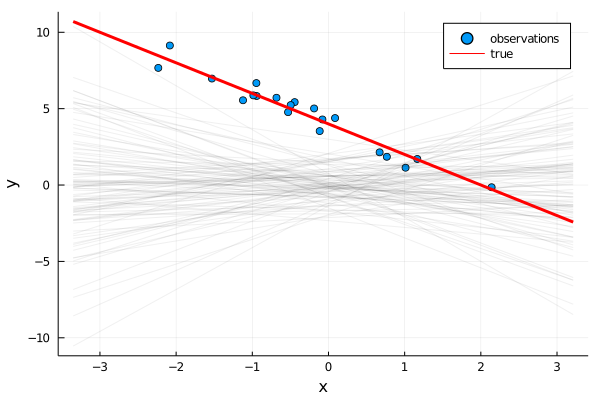

In [9]:
# Plot data
scatter(x, y, xlabel="x", ylabel="y", label="observations")

# Plot samples from prior
β₀samples, β₁samples = sample(prior, 100) |>
    x -> Array(sample(prior, 100)["β₀"]), 
         Array(sample(prior, 100)["β₁"])

xi = LinRange(minimum(x)*1.5, maximum(x)*1.5, 10)
for (β₀, β₁) in zip(β₀samples, β₁samples)
    plot!(xi, linear_regression.(xi, β₀, β₁), 
          label=false, color=:black, alpha=0.06)
end

# Plot true regression line
LinRange(minimum(x)*1.5, maximum(x)*1.5, 50) |>
    x -> plot!(x, linear_regression.(x, β₀, β₁), label="true", lw=3, color=:red)

**SPOT THE DELIBERATE MISTAKE:** We can see that sample predictions do not really overlap the data very well in this example. This is because we did not standardise our data! So we could resolve this by either standardising the data, or by changing our prior beliefs.

**Side note:** It is fine to be concerned about the prior beliefs of particular model parameters. But another way of looking at it is what really matters is how those prior beliefs influence your predictions of what data is likely or unlikely in your model.

## Sample from the posterior

In [10]:
posterior = sample(bayesian_linear_regression(x, y), NUTS(1000, .95), MCMCThreads(), 2000, 4)

┌ Info: Found initial step size
│   ϵ = 0.203125
└ @ Turing.Inference /Users/benjamv/.julia/packages/Turing/XLLTf/src/inference/hmc.jl:188
┌ Info: Found initial step size
│   ϵ = 0.00625
└ @ Turing.Inference /Users/benjamv/.julia/packages/Turing/XLLTf/src/inference/hmc.jl:188
┌ Info: Found initial step size
│   ϵ = 0.2
└ @ Turing.Inference /Users/benjamv/.julia/packages/Turing/XLLTf/src/inference/hmc.jl:188
┌ Info: Found initial step size
│   ϵ = 0.0125
└ @ Turing.Inference /Users/benjamv/.julia/packages/Turing/XLLTf/src/inference/hmc.jl:188


Chains MCMC chain (2000×15×4 Array{Float64,3}):

Iterations        = 1:2000
Thinning interval = 1
Chains            = 1, 2, 3, 4
Samples per chain = 2000
parameters        = β₀, β₁, σ
internals         = acceptance_rate, hamiltonian_energy, hamiltonian_energy_error, is_accept, log_density, lp, max_hamiltonian_energy_error, n_steps, nom_step_size, numerical_error, step_size, tree_depth

Summary Statistics
  parameters      mean       std   naive_se      mcse         ess      rhat 
      Symbol   Float64   Float64    Float64   Float64     Float64   Float64 

          β₀    3.8863    0.1461     0.0016    0.0021   5495.9068    1.0004
          β₁   -2.0666    0.1263     0.0014    0.0016   5906.4592    0.9998
           σ    0.6048    0.1114     0.0012    0.0016   5469.3643    0.9997

Quantiles
  parameters      2.5%     25.0%     50.0%     75.0%     97.5% 
      Symbol   Float64   Float64   Float64   Float64   Float64 

          β₀    3.5838    3.7946    3.8914    3.9821    4.1656
      

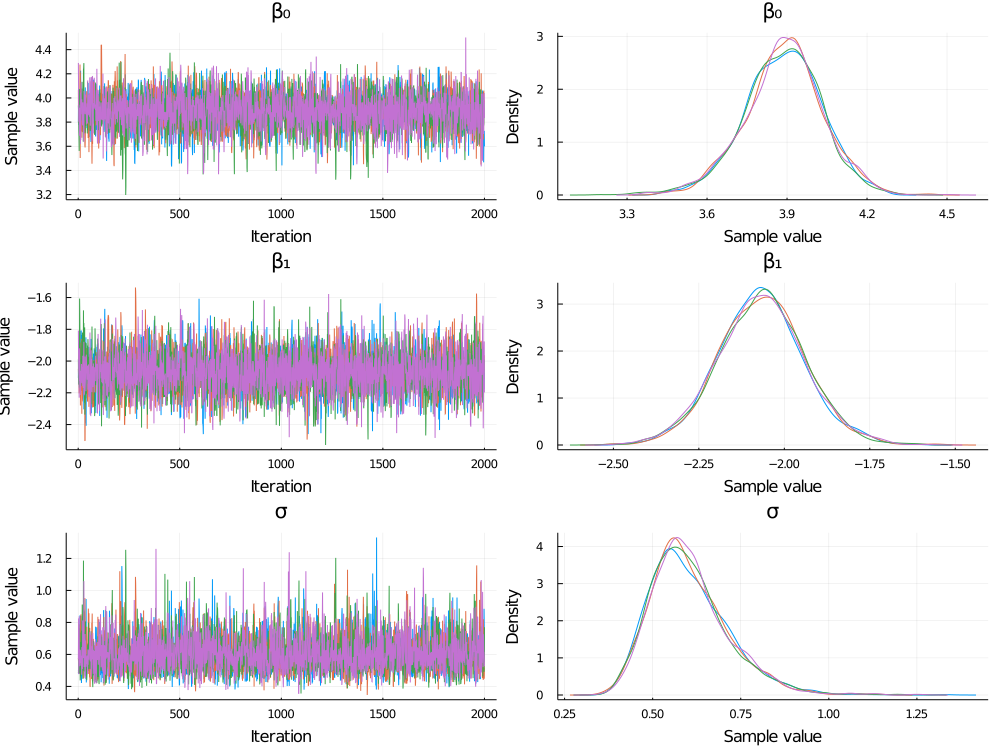

In [11]:
plot(posterior)

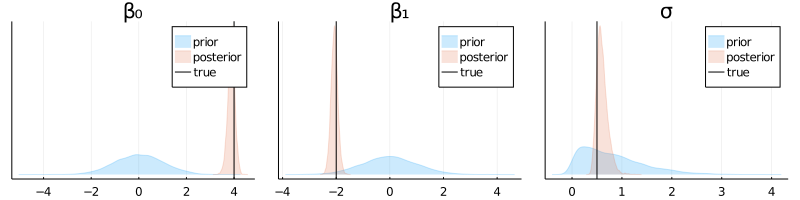

In [12]:
plot(layout=(1, 3), size=(800, 200))
for (i, param) in enumerate([:β₀, :β₁, :σ])
    density!(prior["$param"], subplot=i, label="prior", fill=true, alpha=0.2)
    density!(vec(Array(posterior["$param"])), subplot=i, label="posterior", fill=true, alpha=0.2)
    vline!([eval(param)], label="true", subplot=i, colour=:black)
    plot!(subplot=i, title="$param", yticks=false)
end
plot!()

## Posterior prediction

In the same way we plotted predictions based upon our prior beliefs, we can now plot our predictions based upon our posterior beliefs about the parameters. This is a useful sanity check that the model and posterior can or can't fit the data well.

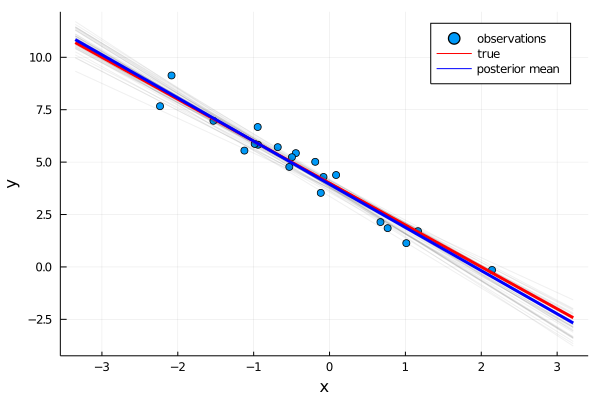

In [14]:
# Plot data
scatter(x, y, xlabel="x", ylabel="y", label="observations")

# Plot samples from posterior
β₀samples, β₁samples = sample(posterior, 10) |>
    x -> vec(Array(sample(posterior, 10)["β₀"])), 
         vec(Array(sample(posterior, 10)["β₁"]))

xi = LinRange(minimum(x)*1.5, maximum(x)*1.5, 10)
for (β₀, β₁) in zip(β₀samples, β₁samples)
    plot!(xi, linear_regression.(xi, β₀, β₁), 
          label=false, color=:black, alpha=0.06)
end

# Plot true regression line
LinRange(minimum(x)*1.5, maximum(x)*1.5, 50) |>
    x -> plot!(x, linear_regression.(x, β₀, β₁), label="true", lw=3, color=:red)

# Plot our posterior mean regression line
μβ₀ = mean(vec(Array(sample(posterior, 10)["β₀"])))
μβ1 = mean(vec(Array(sample(posterior, 10)["β₁"])))
plot!(xi, linear_regression.(xi, μβ₀, μβ1), label="posterior mean", lw=3, color=:blue)

## Summary
- The code to describe a Bayesian linear regression model is extremely simple.
    1. Define our prior beliefs over parameters
    2. Describe how those parameters relate to our data (this is the model)
    3. Form a likelihood function (e.g. data is normally distributed around the predicted mean)
- We can represent our prior and posterior beliefs by a set of samples from a distribution.
- Check the quality of the samples by looking at the 'traces'
- We can plot our prior and posterior beliefs and how those related to predictions to check our model.
- While not discussed here, we can draw research conclusions based on either Bayes Factors or 95% credible intervals of our posteriors.

To underscore how accessible this is, if you were doing this on real data, the core code you need is along the lines of:

```julia
using Turing

# Load your (x, y) data here

@model function bayesian_linear_regression(x, y)
    β₀ ~ Normal(0, 1)
    β₁ ~ Normal(0, 1)
    σ ~ TruncatedNormal(0, 1, 0, Inf)
    @. y ~ Normal(linear_regression(x, β₀, β₁), σ)
end

prior = sample(bayesian_linear_regression(x, y), Prior(), 5_000);
posterior = sample(bayesian_linear_regression(x, y), NUTS(1000, .95), MCMCThreads(), 2000, 4)

# Check inference.
# Do something with your data, and samples from prior and posterior.
# Research conclusions.
```